# **UC1. What different types of SD-WAN devices do I have deployed?**

 Managing thousands of network and cloud entities requires distinguishing roles and configurations. Identifying similarities and differences in data helps optimize operations, especially for users or subscribers.

Clustering techniques group similar entities based on specific attributes, identifying patterns automatically. This helps optimize operational decisions by organizing entities with common characteristics.

# Connection to drive and path definition (Just for Google Colab Lab)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
path_files ='/content/drive/MyDrive/Colab Notebooks/Files'

# ***OR***

# Connection path definition (Just for AWS Jupiter Notebook)

In [ ]:
import sys
path_files ='./Files'

# Import libraries

In [ ]:
pip install seaborn

In [ ]:
pip install scikit-learn

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from datetime import datetime, timedelta
from os.path import join


# [1] Data Collection

Read DataSet for processing





In [4]:
metric_df=pd.read_csv(join(path_files,'mem_and_cpu_utilization_sdwan_metric.csv'),index_col=0)

In [5]:
metric_df

,timestamp,cpu_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address,mem_utilization
0,1743516061,NaN,E-1-1,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.1,30.0
1,1743516061,33.0,E-1-1,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.1,NaN
2,1743516061,NaN,E-1-2,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.2,32.0
3,1743516061,32.0,E-1-2,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.2,NaN
4,1743516061,NaN,E-2-1,Meraki,MX67,meraki,16.160,hw-mx67-0001,vedge_branch,10.3.2.1,30.0
...,...,...,...,...,...,...,...,...,...,...,...
395,1743516061,11.0,E-99-2,Meraki,MX67,meraki,16.170,hw-mx67-0001,vedge_branch,10.3.99.2,NaN
396,1743516061,NaN,E-100-1,Meraki,MX450,meraki,18.101,hw-mx450-0002,vedge_hub,10.3.100.1,79.0
397,1743516061,31.0,E-100-1,Meraki,MX450,meraki,18.101,hw-mx450-0002,vedge_hub,10.3.100.1,NaN
398,1743516061,NaN,E-100-2,Meraki,MX450,meraki,18.101,hw-mx450-0002,vedge_hub,10.3.100.2,75.0


# [2] Data Preprocessing

Fill missing values with 0

In [6]:
metric_df = metric_df.fillna(0)

In [7]:
metric_df

,timestamp,cpu_utilization,device_name,vendor,model,os,version,hw_revision,role,ip_address,mem_utilization
0,1743516061,0.0,E-1-1,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.1,30.0
1,1743516061,33.0,E-1-1,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.1,0.0
2,1743516061,0.0,E-1-2,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.2,32.0
3,1743516061,32.0,E-1-2,Meraki,MX450,meraki,18.101,hw-mx450-0001,vedge_hub,10.3.1.2,0.0
4,1743516061,0.0,E-2-1,Meraki,MX67,meraki,16.160,hw-mx67-0001,vedge_branch,10.3.2.1,30.0
...,...,...,...,...,...,...,...,...,...,...,...
395,1743516061,11.0,E-99-2,Meraki,MX67,meraki,16.170,hw-mx67-0001,vedge_branch,10.3.99.2,0.0
396,1743516061,0.0,E-100-1,Meraki,MX450,meraki,18.101,hw-mx450-0002,vedge_hub,10.3.100.1,79.0
397,1743516061,31.0,E-100-1,Meraki,MX450,meraki,18.101,hw-mx450-0002,vedge_hub,10.3.100.1,0.0
398,1743516061,0.0,E-100-2,Meraki,MX450,meraki,18.101,hw-mx450-0002,vedge_hub,10.3.100.2,75.0


Aggregate metrics by device name

In [8]:
new_metric_df = metric_df.groupby('device_name').sum(['cpu_utilization','memory_utilization'])

In [9]:
new_metric_df

,timestamp,cpu_utilization,version,mem_utilization
device_name,,,,
E-1-1,3487032122,33.0,36.202,30.0
E-1-2,3487032122,32.0,36.202,32.0
E-10-1,3487032122,30.0,32.320,33.0
E-10-2,3487032122,34.0,32.320,30.0
E-100-1,3487032122,31.0,36.202,79.0
...,...,...,...,...
E-97-2,3487032122,80.0,32.340,30.0
E-98-1,3487032122,10.0,32.340,30.0
E-98-2,3487032122,11.0,32.340,30.0


Drop timestamp column

In [10]:
new_metric_df.drop(columns=['timestamp'],inplace=True)

In [11]:
new_metric_df

,cpu_utilization,version,mem_utilization
device_name,,,
E-1-1,33.0,36.202,30.0
E-1-2,32.0,36.202,32.0
E-10-1,30.0,32.320,33.0
E-10-2,34.0,32.320,30.0
E-100-1,31.0,36.202,79.0
...,...,...,...
E-97-2,80.0,32.340,30.0
E-98-1,10.0,32.340,30.0
E-98-2,11.0,32.340,30.0


timestamp is not relevant in this use case, we will focus on the memory utilization column, and the device_name columns. All other columns will be ignored for the moment.

# Exploratory Data Analysis (EDA)

Histogram: Memory Utilization

Text(0.5, 1.0, 'Memory utilization in SD-WAN devices')

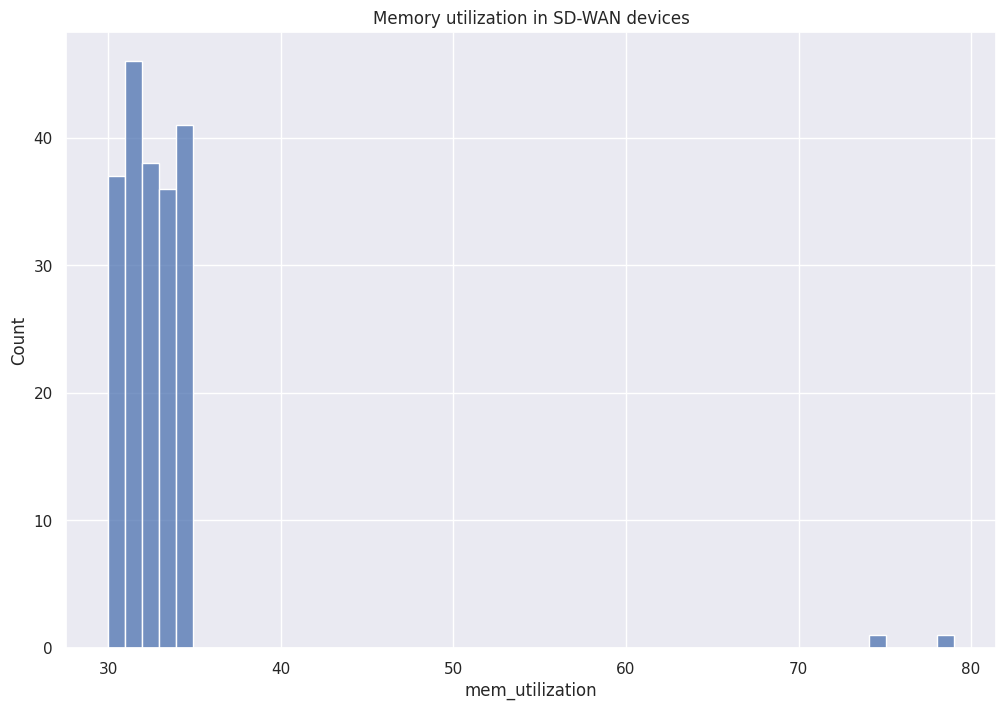

In [12]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='mem_utilization', bins=50)
plt.title('Memory utilization in SD-WAN devices')

Histogram: CPU Utilization

Text(0, 0.5, '% utilization')

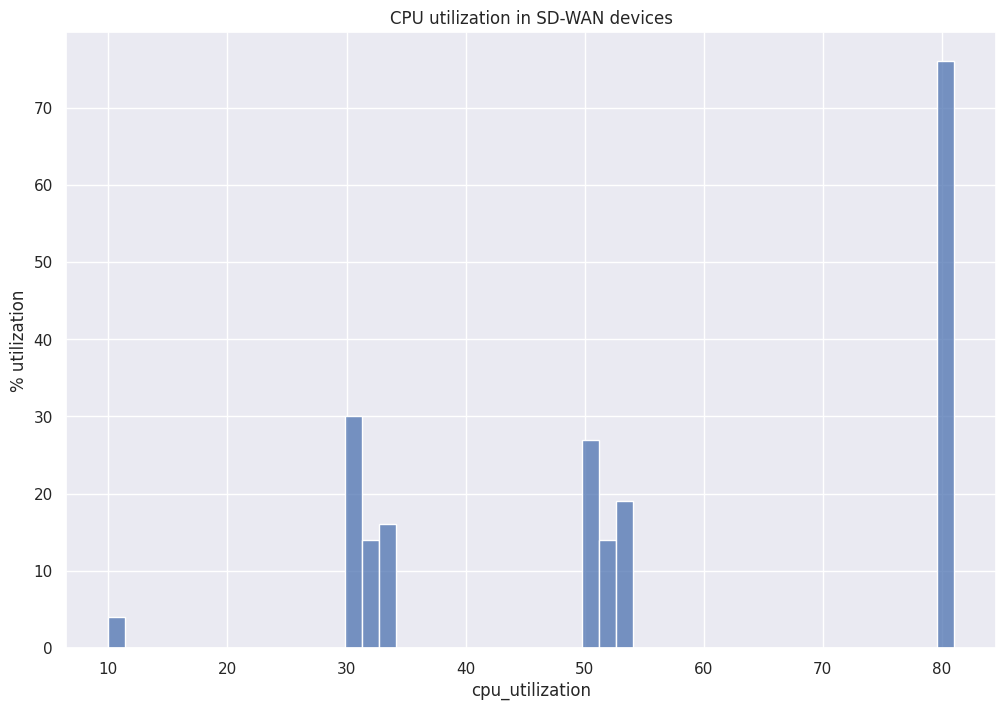

In [13]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='cpu_utilization', bins=50)
plt.title('CPU utilization in SD-WAN devices')
plt.ylabel('% utilization')

Joint Histogram: CPU vs Memory

Text(0, 0.5, '% Mem utilization')

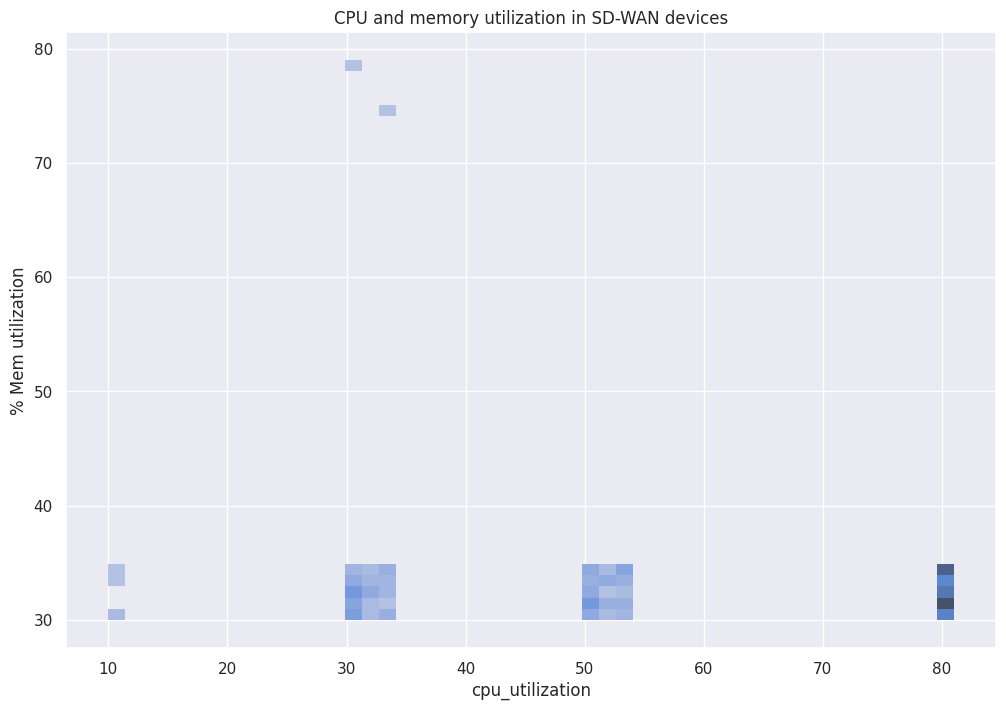

In [14]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization', bins=50)
plt.title('CPU and memory utilization in SD-WAN devices')
plt.ylabel('% Mem utilization')

# Preprocessing for Clustering Analysis

Select features

In [15]:
X = new_metric_df[['mem_utilization','cpu_utilization']].values


# Method 1: DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**Approach 1:** It is a density-based clustering algorithm that identifies groups of points in a dataset without the need to specify the number of clusters in advance. DBSCAN is useful when we do not know how many clusters there are and want to detect structures based on data density, as well as identify outliers.



# [3] Data Normalization




In [16]:
scaler = StandardScaler()
scaler = scaler.fit(X)
X_scaled=scaler.transform(X)

# [4] Apply Clustering method (DBSCAN)



Compute nearest neighbors

In [17]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

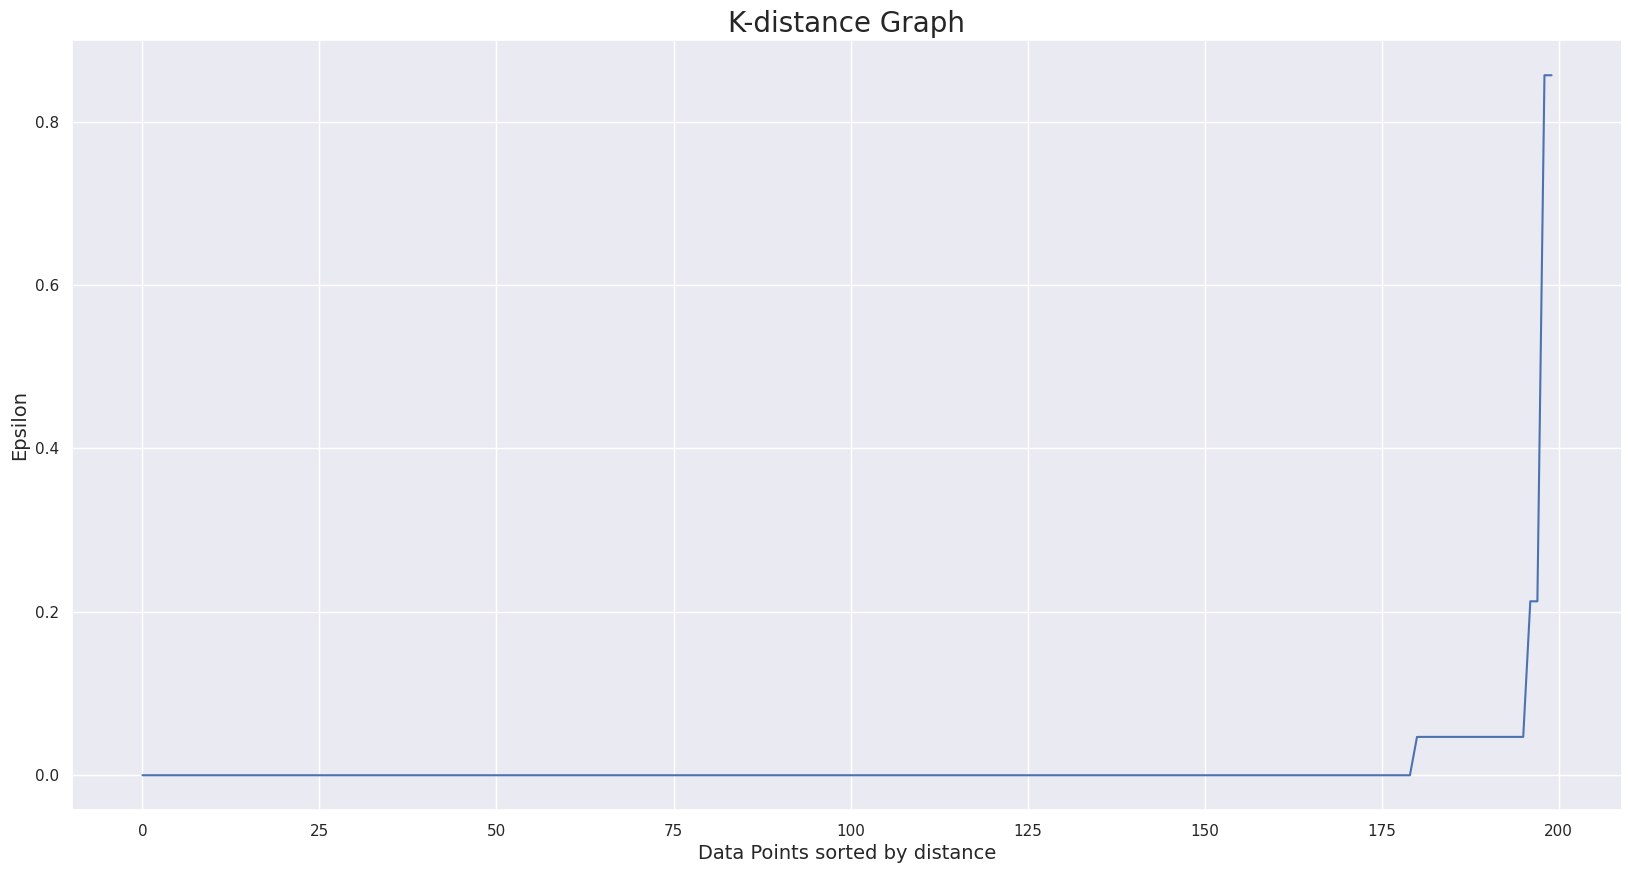

In [18]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

Defines two key parameters:  
   - **ε (epsilon):** The maximum distance within which points are considered to be in the same neighborhood.  
   - **MinPts (minimum points):** The minimum number of points required in a neighborhood to be considered a "core" of a cluster.

**What does this graph show?**
This is known as the K-distance graph, and it's used to help determine the optimal value for eps (epsilon) in the DBSCAN clustering algorithm.

**What does the graph represent?**
X-axis: Indices of data points, sorted by increasing distance to their second nearest neighbor (since n_neighbors=2 was used).

Y-axis: Distance to the second nearest neighbor.

**What are we looking for?**
The "elbow" of the curve — the point where the slope changes sharply — is a good estimate for eps.

Before the elbow: Points are in dense regions (clusters), so their nearest neighbor distances are small.



Run DBSCAN with estimated eps

In [19]:
dbscan=DBSCAN(eps=0.8,min_samples=10)
dbscan.fit(X_scaled)

DBSCAN(eps=0.8, min_samples=10)

Add labels to DataFrame

In [20]:
dbscan.labels_

array([ 0,  0,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1])

# [5] Visualize DBSCAN results

Text(0.5, 1.0, 'CPU and memory utilization clusters with DBSCAN in SD-WAN devices')

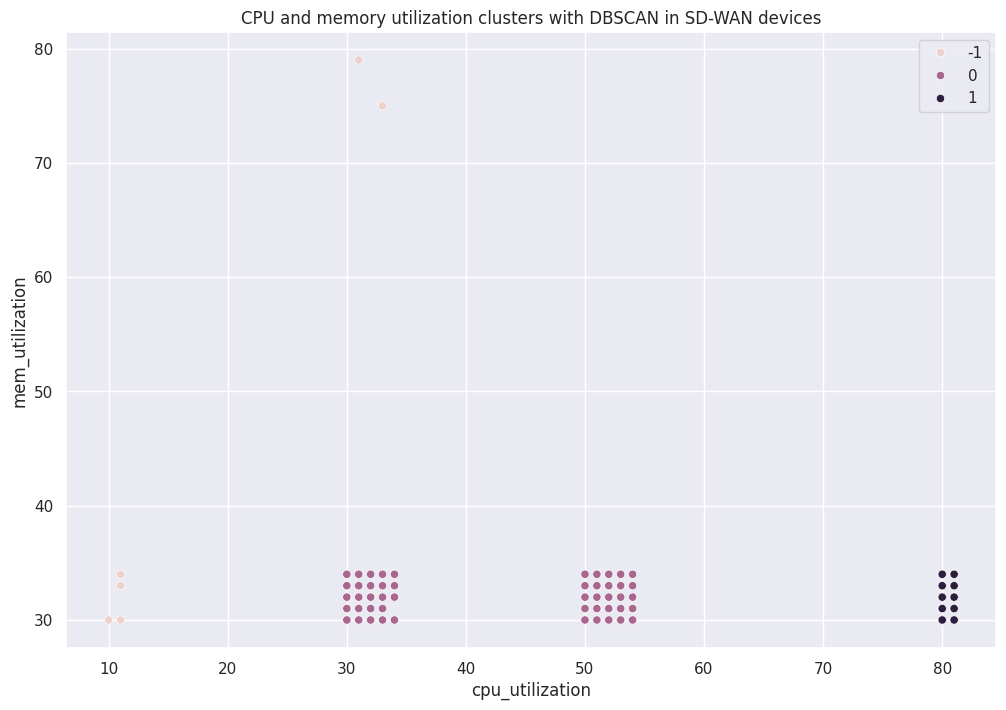

In [21]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue=dbscan.labels_)
plt.title('CPU and memory utilization clusters with DBSCAN in SD-WAN devices')

Advantages of DBSCAN:  
✅ Does not require defining the number of clusters (K) in advance.  
✅ Automatically identifies outliers.  
✅ Works well with arbitrarily shaped and differently sized clusters.

Disadvantages of DBSCAN:  
❌ Sensitive to the choice of **ε** and **MinPts**.  
❌ Does not perform well with high-dimensional datasets.  
❌ Struggles with clusters that have highly variable densities.

# Method 2: K-Means

**Approach 2:** K-Means is a clustering algorithm that groups data into K clusters based on the similarity of their features. It is one of the most popular and efficient algorithms for data segmentation.

In machine learning, the common approach is brute force: repeating the process multiple times to find the best result. The Elbow method follows this principle by running K-means for different values of K to determine the optimal number of clusters. We iterate over various K values, executing the K-means model in each iteration with the `n_clusters` variable (corresponding to K) and storing the WSS results for each iteration.

### **Elbow Method for Choosing K**  
To determine the optimal number of clusters, K-Means is run with different K values, measuring the **Within-Cluster Sum of Squares (WSS)**. Then, a plot of **K vs. WSS** is created, and the optimal K is identified where the WSS reduction slows down significantly.

Elbow method to determine optimal K

# [4] Apply Clustering method (K-Means)





In [22]:
wss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i,init="k-means++",random_state=42)
  kmeans.fit(X_scaled)
  wss.append(kmeans.inertia_)


Text(0.5, 1.0, 'Elbow method to select K number of clusters')

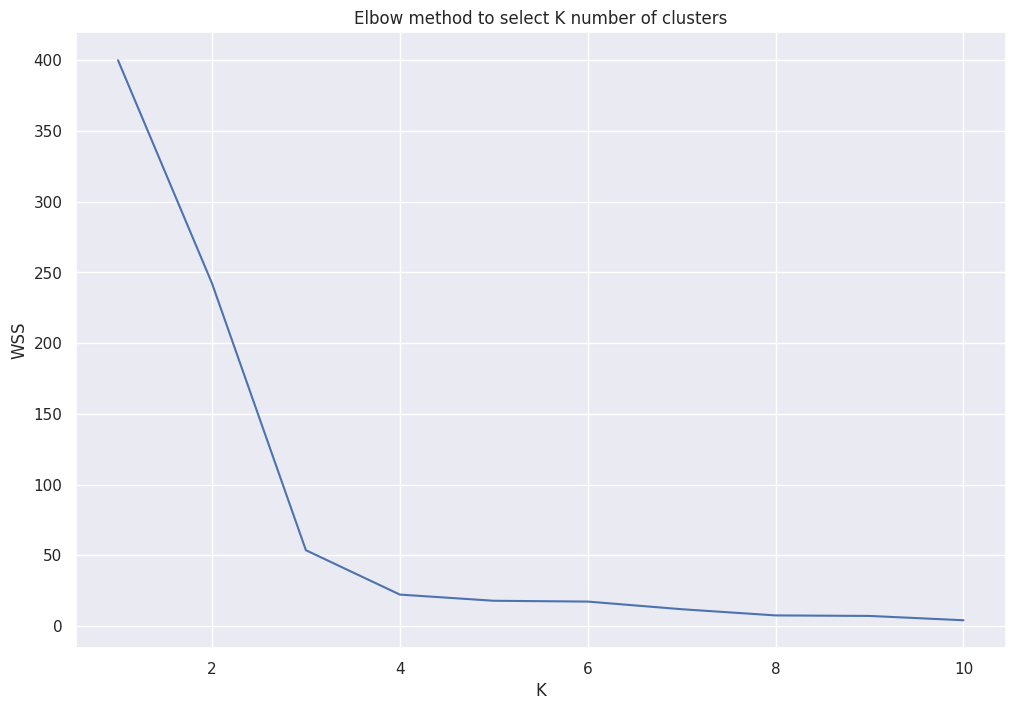

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x = range(1,11), y = wss)
plt.ylabel('WSS')
plt.xlabel('K')
plt.title('Elbow method to select K number of clusters')

Apply KMeans with chosen K

Example with K=3 >>>

In [24]:
K = 3

In [25]:
KMeans_model = KMeans(n_clusters=K,init="k-means++",random_state=42)
KMeans_clusters = KMeans_model.fit_predict(X_scaled)
new_metric_df['cluster']=KMeans_clusters

# [5] Visualize K-Means results



Text(0.5, 1.0, 'CPU and memory utilization clusters with K-means in SD-WAN devices')

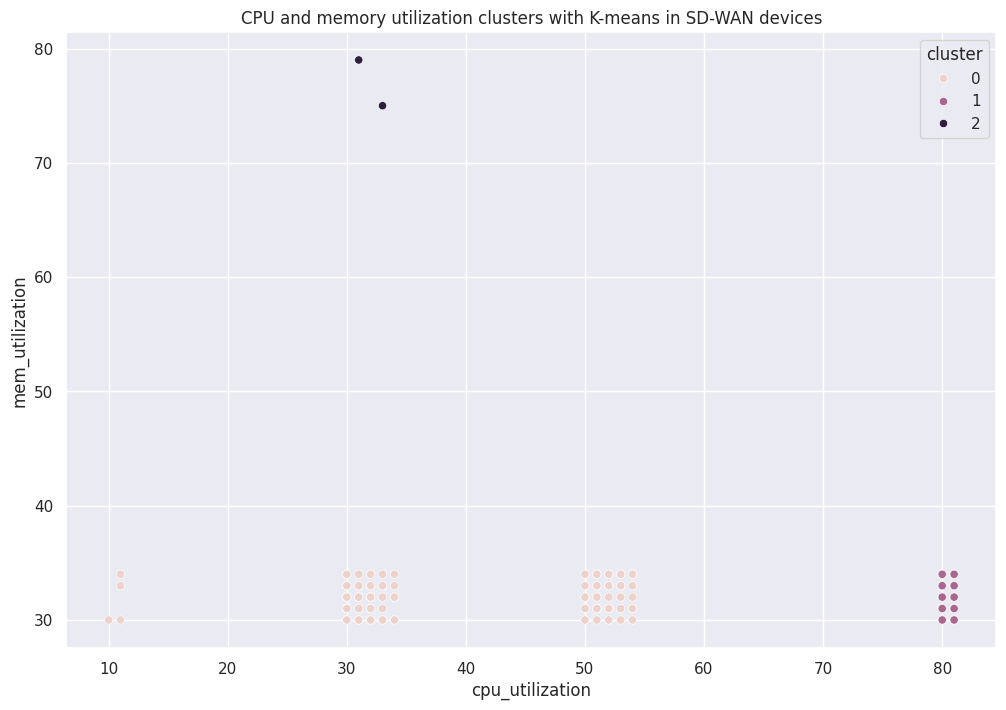

In [26]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='cluster')
plt.title('CPU and memory utilization clusters with K-means in SD-WAN devices')

 **Advantages of K-Means**  
✅ Fast and scalable for large datasets.  
✅ Works well when clusters have spherical shapes and similar sizes.  
✅ Easy to implement and interpret.  

 **Disadvantages of K-Means**  
❌ Requires specifying K in advance (though the Elbow Method helps choose it).  
❌ Struggles with irregularly shaped clusters or varying densities.  
❌ Sensitive to outliers and the choice of initial centroids.

# Method 3: Hierarchical Clustering

**Approach 3:** Hierarchical clustering is a clustering method that organizes data into a hierarchical structure, in the form of a dendrogram (a clustering tree). Unlike K-Means, it does not require defining the number of clusters in advance and allows visualizing the relationships between the data.

Compute linkage matrix

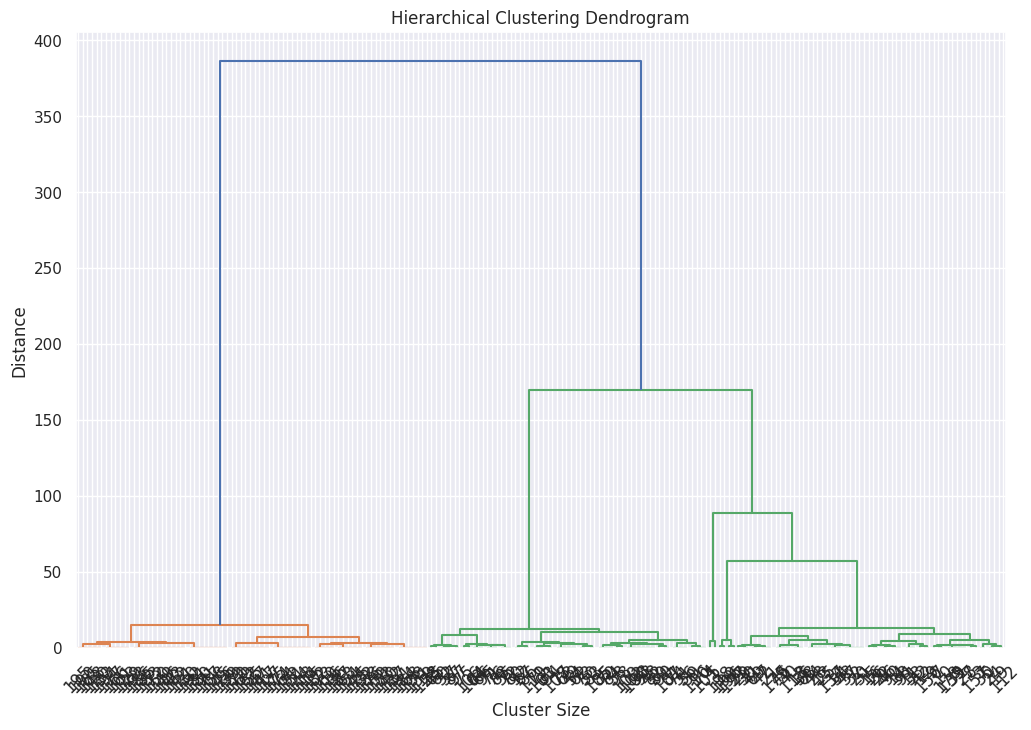

In [27]:
Z=linkage(X,'ward')

# Plotting Dendogram
dendrogram(Z, leaf_rotation=45., leaf_font_size=12.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.rcParams["figure.figsize"] = (14,6)
plt.show()

This text explains how to interpret a **dendrogram** (a graphical representation used in hierarchical clustering) to determine the number of clusters in a dataset. Each horizontal line represents a cluster, and its position on the **y-axis** (distance) shows the separation between clusters. The higher the value on the **y-axis**, the greater the distance between clusters, indicating that they are likely to be different from each other.

The goal is to find a "cut-off point" in the graph— a horizontal distance at which clusters should be separated. In this case, the cut-off is between values **100 and 150**, resulting in **3 clusters** since three vertical lines intersect the horizontal line. After determining the cut-off, the **Hierarchical Agglomerative Clustering** algorithm can be applied to label data points with their corresponding cluster labels. The result (3 clusters) is consistent with what was obtained using **K-means**, confirming the validity of the results.



In [28]:
K=3

In [29]:
model_hcluster = AgglomerativeClustering(n_clusters=K,linkage='ward')
model_hcluster.fit(X)

AgglomerativeClustering(n_clusters=3)

In [30]:
new_metric_df['hcluster']=model_hcluster.labels_

# [5] Visualize Hirarchical Clustering results

Text(0.5, 1.0, 'CPU and memory utilization clusters with Agglomerative Hierarchical Clustering in SD-WAN devices')

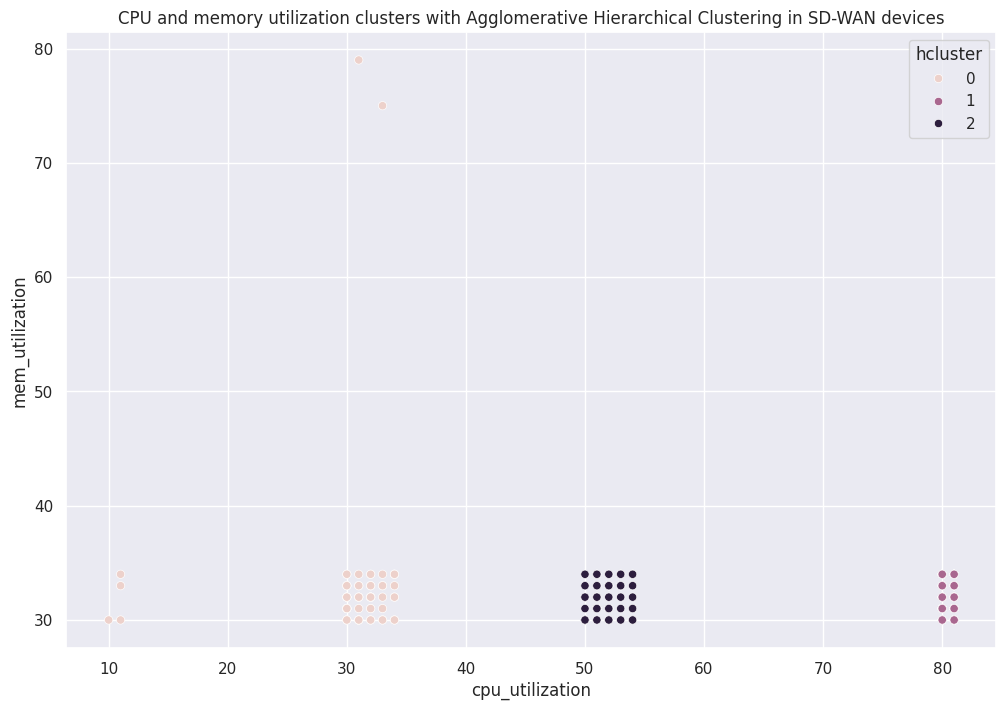

In [31]:
sns.set(rc={'figure.figsize':(12,8)})
sns.scatterplot(data=new_metric_df,x='cpu_utilization', y='mem_utilization',hue='hcluster')
plt.title('CPU and memory utilization clusters with Agglomerative Hierarchical Clustering in SD-WAN devices')

### **Advantages of Hierarchical Clustering**  
✅ Does not require defining the number of clusters (K) in advance.  
✅ Generates a dendrogram that helps visualize the relationships between the data.  
✅ Works well when clusters have natural hierarchical structures.  

### **Disadvantages of Hierarchical Clustering**  
❌ Computationally expensive for large datasets.  
❌ Does not handle outliers well.  
❌ Cannot be "re-adjusted" once clustering is done (unlike K-Means).